# Import data

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request 
import math
import pywt
from typing import List
from ipywidgets import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [22]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
path = "/content/gdrive/MyDrive/Universidade/ADAR - Projeto 1/Data/filtered_data.csv"
data = pd.read_csv(path, sep=',')

time = data["times"]
sleepstage = data["sleepstage"]
sleepstage_parsed = data["sleepstage_parsed"]

columns_names = list(data.columns.values)
columns_names = columns_names[0:-3]
data.head()

,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1,times,sleepstage,sleepstage_parsed
0,0.538422,0.576926,0.536077,0.476028,0.568046,0.497653,0.537291,0.502172,0.508512,0.483759,0.457779,0.52569,0.524454,180.000000,W,0
1,0.538422,0.576926,0.536077,0.476028,0.568046,0.497653,0.537291,0.502172,0.508512,0.483759,0.457779,0.52569,0.524454,180.007812,W,0
2,0.538422,0.576926,0.536077,0.476028,0.568046,0.497653,0.537291,0.502172,0.508512,0.483759,0.457779,0.52569,0.524454,180.015625,W,0
3,0.538422,0.576927,0.536077,0.476028,0.568046,0.497653,0.537291,0.502172,0.508512,0.483759,0.457779,0.52569,0.524454,180.023438,W,0
4,0.538422,0.576927,0.536078,0.476029,0.568047,0.497653,0.537292,0.502173,0.508513,0.483759,0.457780,0.52569,0.524454,180.031250,W,0


# Windowing Signal

In [24]:
def windowing_signal(df_signal: pd.DataFrame, fs: int, window_sec_length: float, overlapping: float=None) -> List[pd.DataFrame]:
  """
  This function applies a sliding window to the signal and divides the signal 
  into multiple portions of signal with window_sec_length seconds (the window 
  length). If the overlapping is None then the sliding window is non-overlap 
  otherwise the step of the sliding window is given by the overlapping variable.
  """
  if overlapping is None:
    step = math.ceil(fs*window_sec_length)
  else:
    step = math.ceil(fs*overlapping)

  segments = []
  for i in range(0, df_signal.shape[0]-step+1, step):
      segments.append(df_signal.iloc[i:i+step])
  return segments

In [25]:
fs = 128
segments = windowing_signal(data, fs, 30)

## Plot

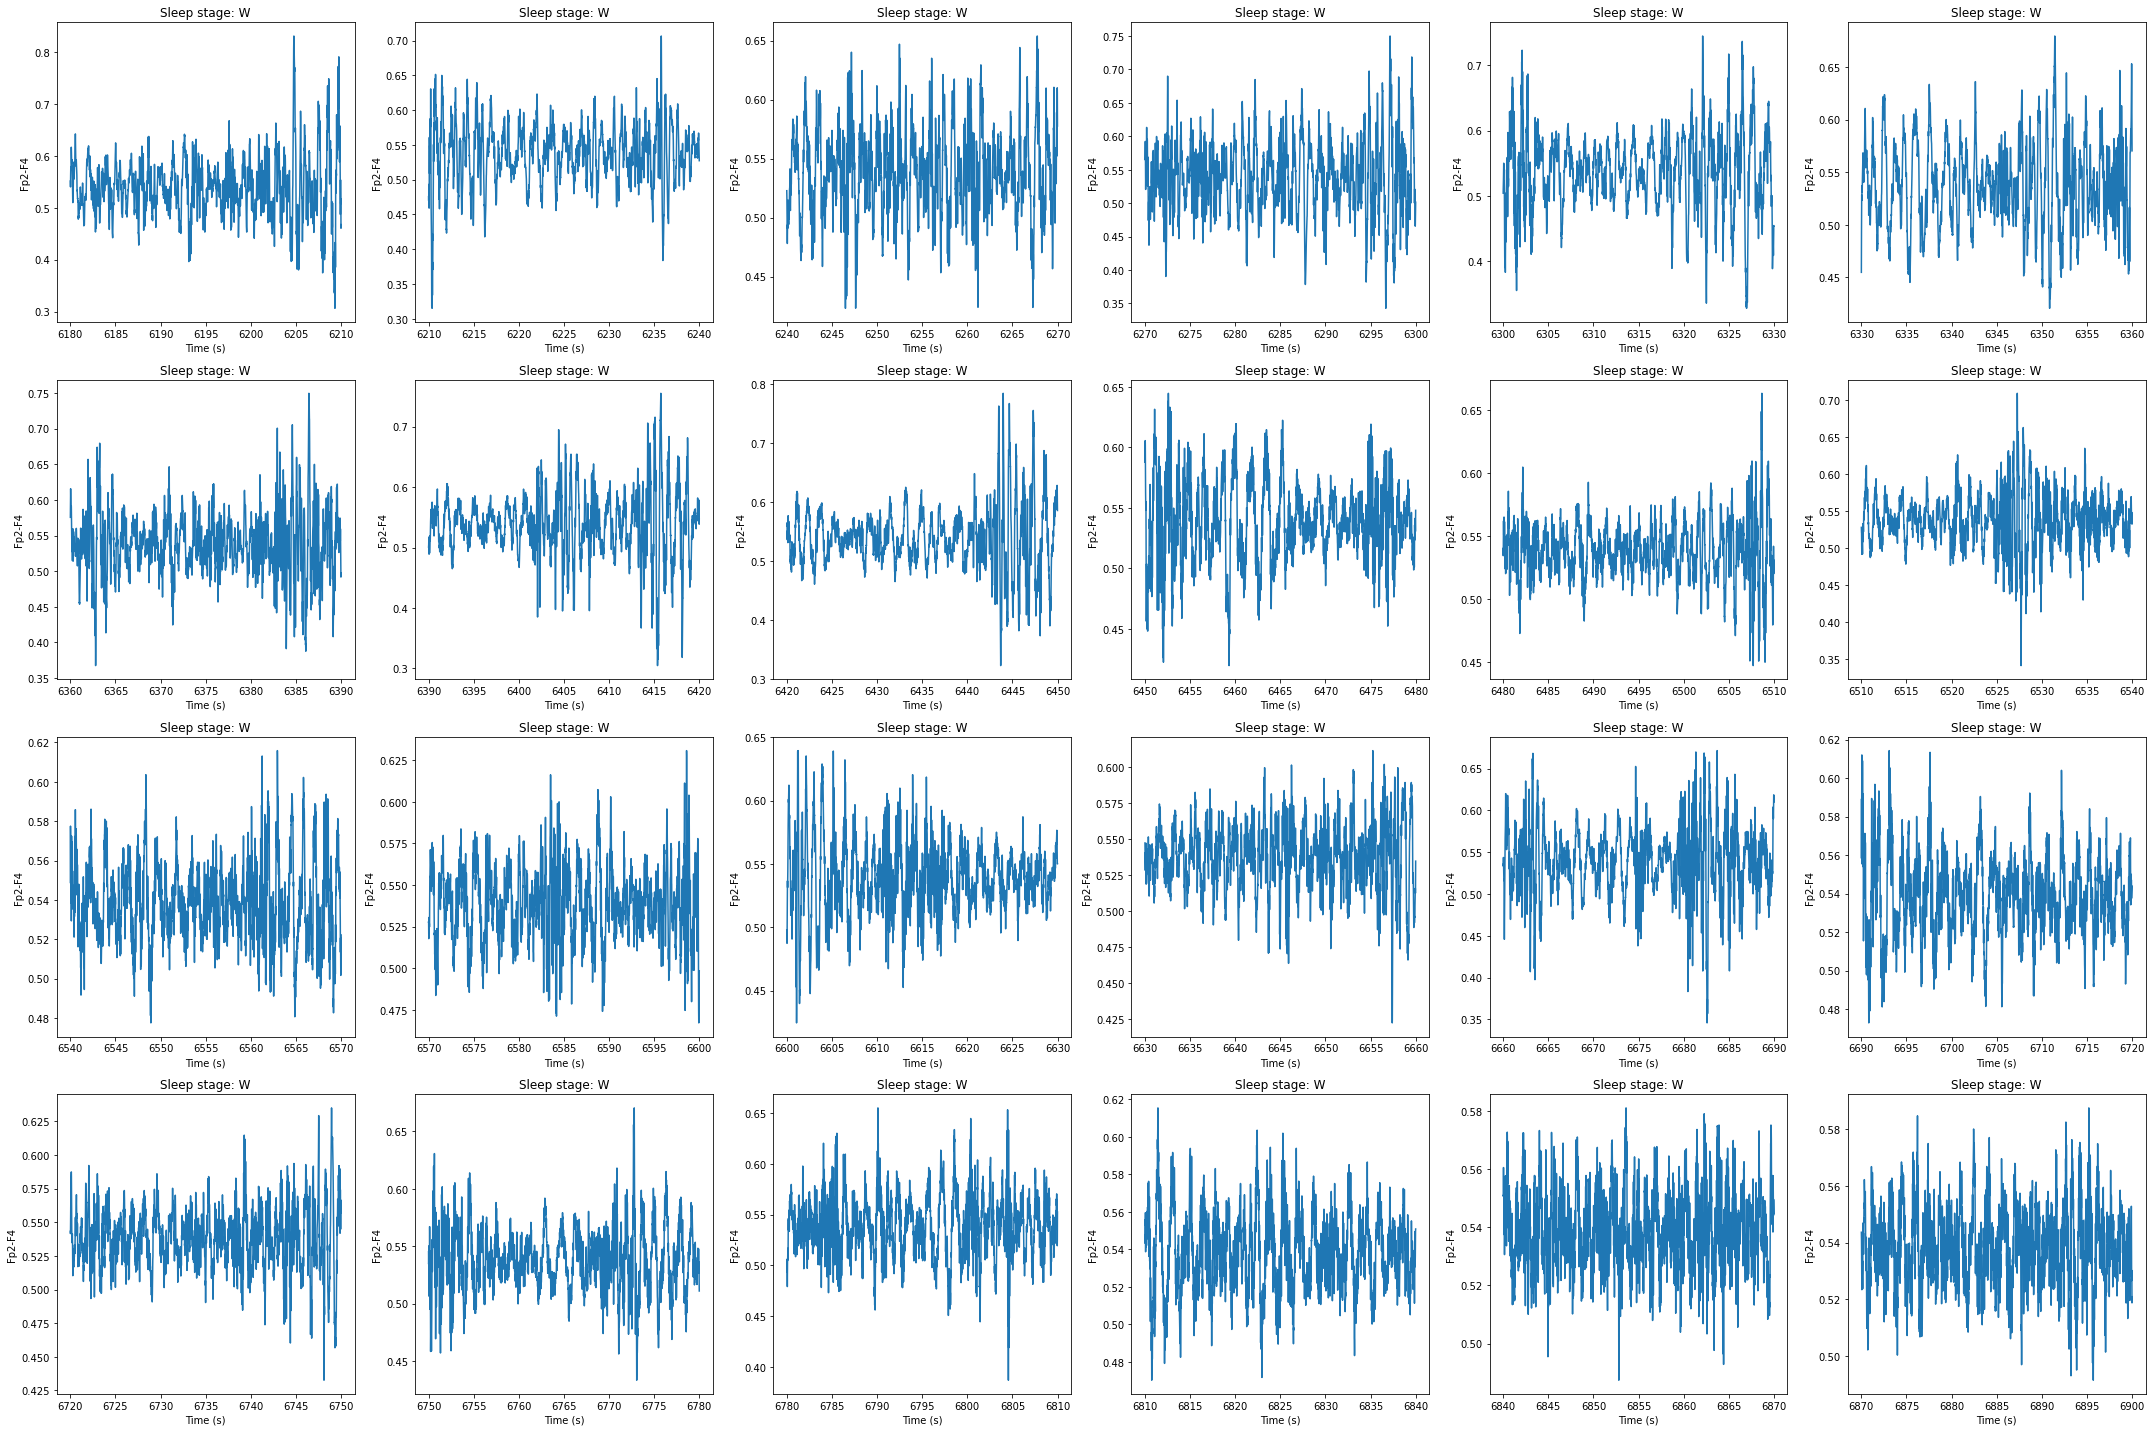

In [26]:
# Fp2-F4; F4-C4; C4-P4; P4-O2; F8-T4; T4-T6; FP1-F3; F3-C3; C3-P3; P3-O1; F7-T3; T3-T5; C4-A1
channel = columns_names[0]
n_rows = 4
n_columns = 6
t = 200

fig = plt.figure(figsize=(n_columns*5, n_rows*5))
for i in range(n_rows*n_columns):
  fig.add_subplot(n_rows, n_columns, i + 1)
  plt.plot(segments[i+t]["times"], segments[i+t][channel])
  plt.xlabel("Time (s)")
  plt.ylabel(channel)
  plt.title(f'Sleep stage: {np.unique(segments[i]["sleepstage"])[0]}')
  plt.tight_layout()

# Interective plot

In [27]:
def wavelet_decomp(family, mother_wavelet, levels, signal_name):
  
  if len(mother_wavelet) > 1:

    result = pywt.Wavelet(mother_wavelet).wavefun(level=levels)
    if len(result) == 3:
      phi, psi, x = result
    else:
      phi_d, psi, phi_r, psi_r, x = result 
      
    single_segment = segments[0][signal_name]
    fig, ax = plt.subplots(levels+4, 1, figsize=(25, 4*(levels+4)))

    ax[0].plot(x, psi)
    ax[0].set_title("Mother wavelet")

    ax[1].plot(single_segment)
    ax[1].set_title("Original Signal - " + signal_name)

    wavelets = pywt.wavedec(single_segment, mother_wavelet, level=levels)
    
    # Reconstruction
    rec = pywt.waverec(wavelets, mother_wavelet)

    for i in range(1, len(wavelets)):
        ax[i+1].plot(wavelets[-i])
        ax[i+1].set_title(f'Decomposition Level: {i} Mother Wavelet:{mother_wavelet}')
    ax[-2].set_title(f'Remaining coef: {i} Mother Wavelet:{mother_wavelet}')
    ax[-2].plot(wavelets[0])
    ax[-1].set_title("Reconstruction")
    ax[-1].plot(rec)
    plt.show()

family_widget = Dropdown(options = pywt.families())
wavelet_widget = Dropdown()

# Define a function that updates the content of y based on what we select for x
def update(*args):
    options = ['']
    options.extend(pywt.wavelist(family_widget.value, kind='discrete'))
    wavelet_widget.options = options

family_widget.observe(update)

interact(wavelet_decomp, family = family_widget,
         mother_wavelet = wavelet_widget, levels=range(2, 10), 
         signal_name = columns_names);

interactive(children=(Dropdown(description='family', options=('haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dm…

# Features

In [28]:
wavelet = "db4"
level = 6

## Create features

In [29]:
energy = pd.DataFrame()
zero_crossing = pd.DataFrame()
variance = pd.DataFrame()
#mean_values = pd.DataFrame()
#median_values = pd.DataFrame()

for channel in columns_names:
  
  names_energy = []  
  energy_channel = np.zeros((len(segments), level+1)) 
  
  names_zero = []  
  zero_channel = np.zeros((len(segments), level+1)) 

  names_var = []
  var_channel = np.zeros((len(segments), level+1)) 

  #names_mean = []
  #mean_channel = np.zeros((len(segments), level+1)) 

  #names_median = []
  #median_channel = np.zeros((len(segments), level+1)) 
  
  for k in range(level+1): 
    names_energy.append(channel+"_"+ str(k) + "_energy")
    names_zero.append(channel+"_"+ str(k) + "_zeros")
    names_var.append(channel+"_"+ str(k) + "_var")
    #names_mean.append(channel+": "+ str(k) + "_mean")
    #names_median.append(channel+": "+ str(k) + "_median")

  for i in range(len(segments)):
    seg = segments[i][channel]
    coeffs = pywt.wavedec(seg, wavelet=wavelet, level=level)
  
    for j in range(len(coeffs)):   
      energy_channel[i,j] = np.sum(coeffs[j]**2)
      zero_channel[i,j] = (len(np.where(np.diff(np.sign(coeffs[j])))[0])/len(coeffs[j]))
      var_channel[i,j] = np.var(abs(coeffs[j]))
      #mean_channel[i,j] = np.mean(abs(coeffs[j]))
      #median_channel[i,j] = np.median(abs(coeffs[j]))
  
  energy = pd.concat([energy, pd.DataFrame(energy_channel, columns=names_energy)], axis=1)
  zero_crossing = pd.concat([zero_crossing, pd.DataFrame(zero_channel, columns=names_zero)], axis=1)
  variance = pd.concat([variance, pd.DataFrame(var_channel, columns=names_var)], axis=1)
  #mean_values = pd.concat([mean_values, pd.DataFrame(mean_channel, columns=names_mean)], axis=1)
  #median_values = pd.concat([median_values, pd.DataFrame(median_channel, columns=names_median)], axis=1)


In [30]:
energy.head()
#zero_crossing.head()
#standard_deviation.head()
#mean_values.head()
#median_values.head()

,Fp2-F4_0_energy,Fp2-F4_1_energy,Fp2-F4_2_energy,Fp2-F4_3_energy,Fp2-F4_4_energy,Fp2-F4_5_energy,Fp2-F4_6_energy,F4-C4_0_energy,F4-C4_1_energy,F4-C4_2_energy,F4-C4_3_energy,F4-C4_4_energy,F4-C4_5_energy,F4-C4_6_energy,C4-P4_0_energy,C4-P4_1_energy,C4-P4_2_energy,C4-P4_3_energy,C4-P4_4_energy,C4-P4_5_energy,C4-P4_6_energy,P4-O2_0_energy,P4-O2_1_energy,P4-O2_2_energy,P4-O2_3_energy,P4-O2_4_energy,P4-O2_5_energy,P4-O2_6_energy,F8-T4_0_energy,F8-T4_1_energy,F8-T4_2_energy,F8-T4_3_energy,F8-T4_4_energy,F8-T4_5_energy,F8-T4_6_energy,T4-T6_0_energy,T4-T6_1_energy,T4-T6_2_energy,T4-T6_3_energy,T4-T6_4_energy,...,F3-C3_2_energy,F3-C3_3_energy,F3-C3_4_energy,F3-C3_5_energy,F3-C3_6_energy,C3-P3_0_energy,C3-P3_1_energy,C3-P3_2_energy,C3-P3_3_energy,C3-P3_4_energy,C3-P3_5_energy,C3-P3_6_energy,P3-O1_0_energy,P3-O1_1_energy,P3-O1_2_energy,P3-O1_3_energy,P3-O1_4_energy,P3-O1_5_energy,P3-O1_6_energy,F7-T3_0_energy,F7-T3_1_energy,F7-T3_2_energy,F7-T3_3_energy,F7-T3_4_energy,F7-T3_5_energy,F7-T3_6_energy,T3-T5_0_energy,T3-T5_1_energy,T3-T5_2_energy,T3-T5_3_energy,T3-T5_4_energy,T3-T5_5_energy,T3-T5_6_energy,C4-A1_0_energy,C4-A1_1_energy,C4-A1_2_energy,C4-A1_3_energy,C4-A1_4_energy,C4-A1_5_energy,C4-A1_6_energy
0,1229.560165,2.066081,0.870442,0.771233,0.492924,0.319497,0.064079,1415.374131,3.612515,1.243943,1.253655,0.796121,0.353472,0.067638,1220.248217,3.957959,1.448100,1.652395,4.564199,1.080237,0.101335,963.022987,3.523021,1.163709,1.421466,3.390544,0.817068,0.086191,1371.872043,4.485018,1.547545,1.515801,1.593826,0.833477,0.146764,1051.404847,3.612388,1.249486,1.489484,4.582279,...,1.489346,1.213126,1.481573,1.406536,0.269265,1098.517631,4.242303,1.645840,1.929781,6.533874,1.494232,0.127403,994.625354,3.725131,1.249848,1.537418,3.947003,0.942397,0.096318,891.525051,2.843345,1.060283,1.052996,1.202722,0.478211,0.076058,1175.349016,5.097206,1.839066,2.192252,6.811974,1.632173,0.164575,1166.199085,2.478143,0.819043,0.957870,1.820233,0.488432,0.057761
1,1225.633388,0.216594,0.130360,0.116358,0.115838,0.158610,0.035682,1412.999452,0.057401,0.053563,0.043697,0.123507,0.052351,0.004535,1219.717523,0.365458,0.398606,0.525688,4.258104,0.820172,0.040034,959.584115,0.248853,0.231042,0.361337,3.140488,0.573094,0.027081,1375.672799,0.196890,0.189294,0.135750,0.741976,0.201772,0.015564,1047.173572,0.419710,0.376380,0.499872,4.470685,...,0.340991,0.236750,0.772317,0.334815,0.029722,1094.980926,0.520107,0.554834,0.751707,6.287231,1.204674,0.059913,989.454273,0.289904,0.266133,0.421284,3.723407,0.674757,0.031692,877.400068,0.205955,0.152066,0.124550,0.772561,0.213424,0.017500,1160.796016,0.609221,0.520761,0.707644,6.603122,1.216731,0.059446,1168.562086,0.132300,0.134228,0.214265,1.603191,0.307423,0.015335
2,1232.092681,0.144191,0.111713,0.136526,0.139561,0.185726,0.032743,1407.042943,0.051947,0.065266,0.060653,0.244320,0.078405,0.005938,1203.978687,0.377337,0.429827,0.649053,5.280771,1.112264,0.048653,949.800313,0.213329,0.255778,0.447319,3.675923,0.800559,0.033846,1361.993971,0.201488,0.173286,0.171436,1.146929,0.270093,0.017179,1039.224468,0.340940,0.404912,0.639729,5.355538,...,0.351313,0.337787,1.362413,0.472245,0.040625,1081.020332,0.513757,0.607002,0.943468,7.783033,1.666133,0.073662,980.549905,0.240353,0.299665,0.524888,4.361693,0.945471,0.039600,886.932420,0.159928,0.197460,0.183986,0.978940,0.283392,0.020960,1159.104649,0.456795,0.609372,0.937539,7.929088,1.682029,0.072965,1154.744672,0.139198,0.148443,0.247146,1.845790,0.413998,0.018755
3,1228.981892,0.237746,0.157308,0.136608,0.172559,0.215558,0.045268,1406.607113,0.100798,0.057184,0.057539,0.299122,0.108718,0.008504,1207.875348,0.476300,0.425372,0.490769,5.773700,1.259823,0.071991,951.556770,0.296463,0.260032,0.337614,3.864237,0.836260,0.051980,1365.957101,0.363160,0.203284,0.170406,1.408059,0.548130,0.113463,1039.788696,0.431593,0.379418,0.467470,5.798543,...,0.477636,0.470038,2.183810,1.040158,0.160686,1086.472976,0.717396,0.598407,0.709834,8.631972,1.863420,0.105491,982.464740,0.353918,0.2970

## Post-processing

### Concatenate

In [31]:
features = pd.concat([energy, zero_crossing, variance], axis=1)
features_names = list(features.columns.values)
features.head()

,Fp2-F4_0_energy,Fp2-F4_1_energy,Fp2-F4_2_energy,Fp2-F4_3_energy,Fp2-F4_4_energy,Fp2-F4_5_energy,Fp2-F4_6_energy,F4-C4_0_energy,F4-C4_1_energy,F4-C4_2_energy,F4-C4_3_energy,F4-C4_4_energy,F4-C4_5_energy,F4-C4_6_energy,C4-P4_0_energy,C4-P4_1_energy,C4-P4_2_energy,C4-P4_3_energy,C4-P4_4_energy,C4-P4_5_energy,C4-P4_6_energy,P4-O2_0_energy,P4-O2_1_energy,P4-O2_2_energy,P4-O2_3_energy,P4-O2_4_energy,P4-O2_5_energy,P4-O2_6_energy,F8-T4_0_energy,F8-T4_1_energy,F8-T4_2_energy,F8-T4_3_energy,F8-T4_4_energy,F8-T4_5_energy,F8-T4_6_energy,T4-T6_0_energy,T4-T6_1_energy,T4-T6_2_energy,T4-T6_3_energy,T4-T6_4_energy,...,F3-C3_2_var,F3-C3_3_var,F3-C3_4_var,F3-C3_5_var,F3-C3_6_var,C3-P3_0_var,C3-P3_1_var,C3-P3_2_var,C3-P3_3_var,C3-P3_4_var,C3-P3_5_var,C3-P3_6_var,P3-O1_0_var,P3-O1_1_var,P3-O1_2_var,P3-O1_3_var,P3-O1_4_var,P3-O1_5_var,P3-O1_6_var,F7-T3_0_var,F7-T3_1_var,F7-T3_2_var,F7-T3_3_var,F7-T3_4_var,F7-T3_5_var,F7-T3_6_var,T3-T5_0_var,T3-T5_1_var,T3-T5_2_var,T3-T5_3_var,T3-T5_4_var,T3-T5_5_var,T3-T5_6_var,C4-A1_0_var,C4-A1_1_var,C4-A1_2_var,C4-A1_3_var,C4-A1_4_var,C4-A1_5_var,C4-A1_6_var
0,1229.560165,2.066081,0.870442,0.771233,0.492924,0.319497,0.064079,1415.374131,3.612515,1.243943,1.253655,0.796121,0.353472,0.067638,1220.248217,3.957959,1.448100,1.652395,4.564199,1.080237,0.101335,963.022987,3.523021,1.163709,1.421466,3.390544,0.817068,0.086191,1371.872043,4.485018,1.547545,1.515801,1.593826,0.833477,0.146764,1051.404847,3.612388,1.249486,1.489484,4.582279,...,0.007096,0.003308,0.001639,0.001035,0.000107,0.109676,0.035942,0.007221,0.005193,0.005483,0.000664,0.000037,0.104410,0.034826,0.006775,0.004668,0.003456,0.000462,0.000032,0.091405,0.025466,0.005442,0.003389,0.001286,0.000316,0.000027,0.136433,0.043227,0.009044,0.006098,0.005755,0.000775,0.000050,0.071493,0.024195,0.004471,0.003051,0.001638,0.000260,0.000021
1,1225.633388,0.216594,0.130360,0.116358,0.115838,0.158610,0.035682,1412.999452,0.057401,0.053563,0.043697,0.123507,0.052351,0.004535,1219.717523,0.365458,0.398606,0.525688,4.258104,0.820172,0.040034,959.584115,0.248853,0.231042,0.361337,3.140488,0.573094,0.027081,1375.672799,0.196890,0.189294,0.135750,0.741976,0.201772,0.015564,1047.173572,0.419710,0.376380,0.499872,4.470685,...,0.001074,0.000358,0.000590,0.000130,0.000005,0.010291,0.003082,0.001654,0.001271,0.004715,0.000477,0.000012,0.006247,0.001931,0.000774,0.000704,0.002812,0.000261,0.000006,0.014357,0.001307,0.000482,0.000187,0.000641,0.000088,0.000003,0.021078,0.003930,0.001668,0.001218,0.005092,0.000488,0.000012,0.005422,0.000698,0.000400,0.000354,0.001174,0.000113,0.000003
2,1232.092681,0.144191,0.111713,0.136526,0.139561,0.185726,0.032743,1407.042943,0.051947,0.065266,0.060653,0.244320,0.078405,0.005938,1203.978687,0.377337,0.429827,0.649053,5.280771,1.112264,0.048653,949.800313,0.213329,0.255778,0.447319,3.675923,0.800559,0.033846,1361.993971,0.201488,0.173286,0.171436,1.146929,0.270093,0.017179,1039.224468,0.340940,0.404912,0.639729,5.355538,...,0.001126,0.000572,0.000996,0.000189,0.000008,0.010736,0.003021,0.001983,0.001421,0.005296,0.000611,0.000014,0.006111,0.001443,0.000954,0.000782,0.003051,0.000359,0.000008,0.003761,0.001106,0.000716,0.000332,0.000698,0.000115,0.000004,0.010102,0.002794,0.001926,0.001448,0.005575,0.000639,0.000014,0.003644,0.000881,0.000476,0.000376,0.001259,0.000156,0.000004
3,1228.981892,0.237746,0.157308,0.136608,0.172559,0.215558,0.045268,1406.607113,0.100798,0.057184,0.057539,0.299122,0.108718,0.008504,1207.875348,0.476300,0.425372,0.490769,5.773700,1.259823,0.071991,951.556770,0.296463,0.260032,0.337614,3.864237,0.836260,0.051980,1365.957101,0.363160,0.203284,0.170406,1.408059,0.548130,0.113463,1039.788696,0.431593,0.379418,0.467470,5.798543,...,0.001484,0.000717,0.001931,0.000523,0.000053,0.016376,0.004231,0.001610,0.001081,0.007180,0.000811,0.000024,0.008528,0.002346,0.000786,0.000605,0.003858,0.000426,0.000015,0.003670,0.001595,0.000515,0.000298,0.001007,0.000309,0.000048,0.013778,0.004463,0.001528,0.001054,0.007138,0.000840,0.000052

### Standardize features

In [32]:
features = StandardScaler().fit_transform(features)
features = pd.DataFrame(features, columns = features_names)

features.head(n=10)

,Fp2-F4_0_energy,Fp2-F4_1_energy,Fp2-F4_2_energy,Fp2-F4_3_energy,Fp2-F4_4_energy,Fp2-F4_5_energy,Fp2-F4_6_energy,F4-C4_0_energy,F4-C4_1_energy,F4-C4_2_energy,F4-C4_3_energy,F4-C4_4_energy,F4-C4_5_energy,F4-C4_6_energy,C4-P4_0_energy,C4-P4_1_energy,C4-P4_2_energy,C4-P4_3_energy,C4-P4_4_energy,C4-P4_5_energy,C4-P4_6_energy,P4-O2_0_energy,P4-O2_1_energy,P4-O2_2_energy,P4-O2_3_energy,P4-O2_4_energy,P4-O2_5_energy,P4-O2_6_energy,F8-T4_0_energy,F8-T4_1_energy,F8-T4_2_energy,F8-T4_3_energy,F8-T4_4_energy,F8-T4_5_energy,F8-T4_6_energy,T4-T6_0_energy,T4-T6_1_energy,T4-T6_2_energy,T4-T6_3_energy,T4-T6_4_energy,...,F3-C3_2_var,F3-C3_3_var,F3-C3_4_var,F3-C3_5_var,F3-C3_6_var,C3-P3_0_var,C3-P3_1_var,C3-P3_2_var,C3-P3_3_var,C3-P3_4_var,C3-P3_5_var,C3-P3_6_var,P3-O1_0_var,P3-O1_1_var,P3-O1_2_var,P3-O1_3_var,P3-O1_4_var,P3-O1_5_var,P3-O1_6_var,F7-T3_0_var,F7-T3_1_var,F7-T3_2_var,F7-T3_3_var,F7-T3_4_var,F7-T3_5_var,F7-T3_6_var,T3-T5_0_var,T3-T5_1_var,T3-T5_2_var,T3-T5_3_var,T3-T5_4_var,T3-T5_5_var,T3-T5_6_var,C4-A1_0_var,C4-A1_1_var,C4-A1_2_var,C4-A1_3_var,C4-A1_4_var,C4-A1_5_var,C4-A1_6_var
0,0.301679,0.735850,0.450743,2.125268,1.006410,0.280505,0.186816,1.193317,5.671554,3.797952,10.995822,7.476258,9.368558,7.935996,0.207608,0.889335,0.249187,2.003372,1.773303,2.593477,2.039126,0.350824,1.603912,0.796704,3.541518,1.879473,3.031877,3.359242,0.528083,2.189695,1.564593,5.612307,3.067646,2.847037,1.907074,0.178743,0.913153,0.351488,2.411906,1.765237,...,0.389612,1.973629,1.879110,4.303535,3.325215,0.450087,0.926339,0.370233,3.236614,1.916966,2.409512,1.459417,1.188191,2.362456,1.640278,6.301025,2.181741,3.723303,4.007624,3.131236,2.939128,2.507748,10.551285,3.862681,1.509699,0.857494,0.956328,1.714070,1.345638,5.954987,2.052778,2.516916,1.486039,1.487244,2.640734,1.721080,6.273054,2.343157,3.743943,3.678742
1,-0.070346,-0.576699,-0.708301,-0.819052,-0.708285,-0.011141,0.032298,0.872485,-0.610477,-0.712635,-0.913971,-0.162508,0.023329,-0.067182,0.176605,-0.697963,-0.798760,-0.703826,1.601005,1.647061,0.312918,0.053630,-0.648834,-0.733861,-0.484400,1.687683,1.758053,0.413169,0.826067,-0.646544,-0.679254,-0.911371,0.830696,0.110530,-0.196434,-0.102736,-0.645383,-0.731148,-0.510150,1.705064,...,-0.709395,-0.991570,-0.338860,-0.274639,-0.310724,-0.587515,-0.692183,-0.807464,-0.637801,1.521384,1.357628,0.093112,-0.506660,-0.611122,-0.690715,-0.410091,1.622600,1.533977,0.188305,-0.200764,-0.595399,-0.645619,-0.876462,1.295449,-0.029820,-0.253670,-0.473581,-0.654653,-0.713038,-0.413638,1.723238,1.190887,-0.066577,-0.446887,-0.620835,-0.709865,-0.513406,1.412097,0.860194,-0.018808
2,0.541611,-0.628082,-0.737505,-0.728378,-0.600412,0.038014,0.016307,0.067727,-0.620114,-0.668291,-0.747070,1.209547,0.831913,0.110733,-0.742854,-0.692714,-0.767584,-0.407409,2.176654,2.710026,0.555618,-0.791906,-0.673276,-0.693268,-0.157880,2.098356,2.945680,0.750345,-0.246370,-0.643502,-0.705701,-0.742679,1.894097,0.406488,-0.170534,-0.631539,-0.683835,-0.695769,-0.097191,2.182184,...,-0.699783,-0.777108,0.519661,0.025767,-0.223062,-0.582862,-0.695196,-0.737704,-0.489054,1.820525,2.110705,0.190734,-0.509006,-0.655264,-0.620496,-0.278833,1.829872,2.602141,0.393008,-0.658975,-0.624781,-0.496432,-0.360895,1.520218,0.149238,-0.223147,-0.609643,-0.723114,-0.640865,-0.112980,1.963471,1.889065,0.030972,-0.498946,-0.595475,-0.664321,-0.459601,1.582883,1.711857,0.091923
3,0.246894,-0.561687,-0.666098,-0.728007,-0.450363,0.092091,0.084459,0.008844,-0.533793,-0.698917,-0.777716,1.831921,1.772671,0.436211,-0.515212,-0.648989,-0.772034,-0.787726,2.454118,3.247016,1.212824,-0.640109,-0.616076,-0.686288,-0.574491,2.242791,3.132084,1.654172,0.064344,-0.536570,-0.656143,-0.747544,2.579824,1.610931,1.373177,-0.594004,-0.639582,-0.727381,-0.605825,2.421055,...,-0.634559,-0.630887,2.496367,1.716262,1.367501,-0.523985,-0.635590,-0.816607,-0.825191,2.791757,3.237051,0.750006,-0.467274,-0.573665,-0.685790,-0.577929,2.531337,3.326989,1.415143,-0.662900,-0.553292,-0.624043,-0.479457,2.753465,1.465678

### Add labels


In [33]:
label = []
for i in range(0, len(segments)):
  x =  segments[i]["sleepstage_parsed"].to_numpy()
  label.append(np.bincount(x).argmax())

label = pd.DataFrame(label, columns=["sleepstage"])

In [34]:
# Remove row 0
features = features.drop(labels=0, axis=0)
features.reset_index(drop=True, inplace=True)

label = label.drop(labels=0, axis=0)
label.reset_index(drop=True, inplace=True)

In [35]:
features = pd.concat([features, label], axis=1)
features.head(n=10)

,Fp2-F4_0_energy,Fp2-F4_1_energy,Fp2-F4_2_energy,Fp2-F4_3_energy,Fp2-F4_4_energy,Fp2-F4_5_energy,Fp2-F4_6_energy,F4-C4_0_energy,F4-C4_1_energy,F4-C4_2_energy,F4-C4_3_energy,F4-C4_4_energy,F4-C4_5_energy,F4-C4_6_energy,C4-P4_0_energy,C4-P4_1_energy,C4-P4_2_energy,C4-P4_3_energy,C4-P4_4_energy,C4-P4_5_energy,C4-P4_6_energy,P4-O2_0_energy,P4-O2_1_energy,P4-O2_2_energy,P4-O2_3_energy,P4-O2_4_energy,P4-O2_5_energy,P4-O2_6_energy,F8-T4_0_energy,F8-T4_1_energy,F8-T4_2_energy,F8-T4_3_energy,F8-T4_4_energy,F8-T4_5_energy,F8-T4_6_energy,T4-T6_0_energy,T4-T6_1_energy,T4-T6_2_energy,T4-T6_3_energy,T4-T6_4_energy,...,F3-C3_3_var,F3-C3_4_var,F3-C3_5_var,F3-C3_6_var,C3-P3_0_var,C3-P3_1_var,C3-P3_2_var,C3-P3_3_var,C3-P3_4_var,C3-P3_5_var,C3-P3_6_var,P3-O1_0_var,P3-O1_1_var,P3-O1_2_var,P3-O1_3_var,P3-O1_4_var,P3-O1_5_var,P3-O1_6_var,F7-T3_0_var,F7-T3_1_var,F7-T3_2_var,F7-T3_3_var,F7-T3_4_var,F7-T3_5_var,F7-T3_6_var,T3-T5_0_var,T3-T5_1_var,T3-T5_2_var,T3-T5_3_var,T3-T5_4_var,T3-T5_5_var,T3-T5_6_var,C4-A1_0_var,C4-A1_1_var,C4-A1_2_var,C4-A1_3_var,C4-A1_4_var,C4-A1_5_var,C4-A1_6_var,sleepstage
0,-0.070346,-0.576699,-0.708301,-0.819052,-0.708285,-0.011141,0.032298,0.872485,-0.610477,-0.712635,-0.913971,-0.162508,0.023329,-0.067182,0.176605,-0.697963,-0.798760,-0.703826,1.601005,1.647061,0.312918,0.053630,-0.648834,-0.733861,-0.484400,1.687683,1.758053,0.413169,0.826067,-0.646544,-0.679254,-0.911371,0.830696,0.110530,-0.196434,-0.102736,-0.645383,-0.731148,-0.510150,1.705064,...,-0.991570,-0.338860,-0.274639,-0.310724,-0.587515,-0.692183,-0.807464,-0.637801,1.521384,1.357628,0.093112,-0.506660,-0.611122,-0.690715,-0.410091,1.622600,1.533977,0.188305,-0.200764,-0.595399,-0.645619,-0.876462,1.295449,-0.029820,-0.253670,-0.473581,-0.654653,-0.713038,-0.413638,1.723238,1.190887,-0.066577,-0.446887,-0.620835,-0.709865,-0.513406,1.412097,0.860194,-0.018808,0
1,0.541611,-0.628082,-0.737505,-0.728378,-0.600412,0.038014,0.016307,0.067727,-0.620114,-0.668291,-0.747070,1.209547,0.831913,0.110733,-0.742854,-0.692714,-0.767584,-0.407409,2.176654,2.710026,0.555618,-0.791906,-0.673276,-0.693268,-0.157880,2.098356,2.945680,0.750345,-0.246370,-0.643502,-0.705701,-0.742679,1.894097,0.406488,-0.170534,-0.631539,-0.683835,-0.695769,-0.097191,2.182184,...,-0.777108,0.519661,0.025767,-0.223062,-0.582862,-0.695196,-0.737704,-0.489054,1.820525,2.110705,0.190734,-0.509006,-0.655264,-0.620496,-0.278833,1.829872,2.602141,0.393008,-0.658975,-0.624781,-0.496432,-0.360895,1.520218,0.149238,-0.223147,-0.609643,-0.723114,-0.640865,-0.112980,1.963471,1.889065,0.030972,-0.498946,-0.595475,-0.664321,-0.459601,1.582883,1.711857,0.091923,0
2,0.246894,-0.561687,-0.666098,-0.728007,-0.450363,0.092091,0.084459,0.008844,-0.533793,-0.698917,-0.777716,1.831921,1.772671,0.436211,-0.515212,-0.648989,-0.772034,-0.787726,2.454118,3.247016,1.212824,-0.640109,-0.616076,-0.686288,-0.574491,2.242791,3.132084,1.654172,0.064344,-0.536570,-0.656143,-0.747544,2.579824,1.610931,1.373177,-0.594004,-0.639582,-0.727381,-0.605825,2.421055,...,-0.630887,2.496367,1.716262,1.367501,-0.523985,-0.635590,-0.816607,-0.825191,2.791757,3.237051,0.750006,-0.467274,-0.573665,-0.685790,-0.577929,2.531337,3.326989,1.415143,-0.662900,-0.553292,-0.624043,-0.479457,2.753465,1.465678,1.847846,-0.564066,-0.622510,-0.752079,-0.626971,2.739500,2.817815,1.576559,-0.460076,-0.569676,-0.698758,-0.578587,2.257410,3.131928,1.788278,0
3,-0.359971,-0.634189,-0.701222,-0.746209,-0.603373,0.015001,0.003168,-0.459851,-0.605428,-0.701335,-0.833460,0.871153,0.673245,0.021324,-0.109692,-0.669808,-0.797820,-0.677448,1.929257,2.508356,0.470154,-0.026466,-0.655486,-0.738977,-0.553420,1.917791,2.628955,0.671580,0.162420,-0.611960,-0.702766,-0.719905,1.715567,0.488980,-0.127536,-0.258639,-0.640287,-0.724007,-0.522302,1.986740,...,-0.840447,1.265357,0.238965,-0.164206,-0.500356,-0.642089,-0.786955,-0.752682,1.965862,1.953982,0.162308,-0.460214,-0.610774,-0.661557,-0.527582,1.888439,2.216962,0.291216,-0.544776,-0.309574,-0.543270,-0.641801,2.0457

# Save data


In [36]:
path = "/content/gdrive/MyDrive/Universidade/ADAR - Projeto 1/Data/features.csv"
features.to_csv(path, index = False) 